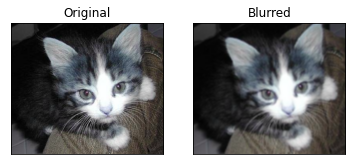

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


img = cv2.imread('cat.png')
blur = cv2.blur(img,(5,5))
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

(([], []), ([], []))

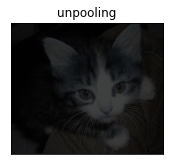

In [3]:
def unpooling(src, scale):
  assert isinstance(scale, int)
  src_h, src_w, channel = src.shape
  dst_h = src_h * scale
  dst_w = src_w * scale
  dst = np.zeros((dst_h, dst_w, channel), dtype=src.dtype)
  dst[::scale, ::scale] = src
  return dst

img_u = unpooling(img, 2)
plt.subplot(122),plt.imshow(img_u),plt.title('unpooling')
plt.xticks([]), plt.yticks([])

In [ ]:
def nearest_interpolation(src, dst_size):
  src_h, src_w, channel = src.shape
  dst_w, dst_h = dst_size
  x_scale = dst_w / src_w
  y_scale = dst_h / src_h
  dst = np.zeros((dst_h, dst_w, channel), dtype=src.dtype)
  for c in range(channel):
    for dst_x in range(dst_w):
      for dst_y in range(dst_h):
        # 计算目标图的当前坐标在源图像中的位置
        # 数学关系：src_x + 0.5 = (dst_x + 0.5) / x_scale
        src_x = int(round((dst_x + 0.5) / x_scale - 0.5))
        src_y = int(round((dst_y + 0.5) / y_scale - 0.5))
        src_x = src_x if src_x > 0 else 0
        src_x = src_x if src_x < src_w else src_w - 1
        src_y = src_y if src_y > 0 else 0
        src_y = src_y if src_y < src_h else src_h - 1
        dst[dst_y, dst_x, c] = src[src_y, src_x, c]
  return dst

img_n = nearest_interpolation(img, (512, 512))
cv2.imshow('show', img_n)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
def nearest_interpolation_v1(src, dst_size):
  src_h, src_w, channel = src.shape
  dst_w, dst_h = dst_size
  x_scale = dst_w / src_w
  y_scale = dst_h / src_h
  dst = np.zeros((dst_h, dst_w, channel), dtype=src.dtype)
  for dst_x in range(dst_w):
    for dst_y in range(dst_h):
      src_x = int(round((dst_x + 0.5) / x_scale - 0.5))
      src_y = int(round((dst_y + 0.5) / y_scale - 0.5))
      src_x = src_x if src_x > 0 else 0
      src_x = src_x if src_x < src_w else src_w - 1
      src_y = src_y if src_y > 0 else 0
      src_y = src_y if src_y < src_h else src_h - 1
      dst[dst_y, dst_x] = src[src_y, src_x]
  return dst

img_n1 = nearest_interpolation_v1(img, (512, 512))
cv2.imshow('show', img_n1)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
def nearest_interpolation_v2(src, dst_size):
  src_h, src_w, channel = src.shape
  dst_w, dst_h = dst_size
  x_scale = dst_w / src_w
  y_scale = dst_h / src_h
  dst_y, dst_x = np.mgrid[:dst_h, :dst_w]
  src_x = np.around((dst_x + 0.5) / x_scale - 0.5).astype(np.int64)
  src_y = np.around((dst_y + 0.5) / y_scale - 0.5).astype(np.int64)
  src_x = np.clip(src_x, 0, src_w-1)
  src_y = np.clip(src_y, 0, src_h-1)
  dst = src[src_y, src_x].copy()
  return dst

img_n2 = nearest_interpolation_v2(img, (512, 512))
cv2.imshow('show', img_n2)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import time
t1 = time.time()
img_n0 = nearest_interpolation(img, (512, 512))
t2 = time.time()
img_n1 = nearest_interpolation_v1(img, (512, 512))
t3 = time.time()
img_n2 = nearest_interpolation_v2(img, (512, 512))
t4 = time.time()
print('Difference 0-1: ', ((img_n0 - img_n1)**2).sum())
print('Difference 0-2: ', ((img_n0 - img_n2)**2).sum())
print('Difference 1-2: ', ((img_n1 - img_n2)**2).sum())
print('v0: %.6f' % (t2 - t1))
print('v1: %.6f' % (t3 - t2))
print('v2: %.6f' % (t4 - t3))

In [ ]:
def bilinear_interpolation(src, dst_size):
  src_h, src_w, channel = src.shape
  dst_w, dst_h = dst_size
  x_scale = dst_w / src_w
  y_scale = dst_h / src_h
  dst = np.zeros((dst_h, dst_w, channel), dtype=src.dtype)
  for c in range(channel):
    for dst_x in range(dst_w):
      for dst_y in range(dst_h):
        src_x = (dst_x + 0.5) / x_scale - 0.5
        src_y = (dst_y + 0.5) / y_scale - 0.5

        src_x1 = int(src_x)
        src_y1 = int(src_y)
        src_x2 = src_x1 + 1
        src_y2 = src_y1 + 1

        def clip(v, vmin, vmax):
          v = v if v >= vmin else vmin
          v = v if v <= vmax else vmax
          return v

        src_x1 = clip(src_x1, 0, src_w-1)
        src_x2 = clip(src_x2, 0, src_w-1)
        src_y1 = clip(src_y1, 0, src_h-1)
        src_y2 = clip(src_y2, 0, src_h-1)
        
        y1_value = (src_x - src_x1) * src[src_y1, src_x2, c] + (src_x2 - src_x) * src[src_y1, src_x1, c]
        y2_value = (src_x - src_x1) * src[src_y2, src_x2, c] + (src_x2 - src_x) * src[src_y2, src_x1, c]
        dst[dst_y, dst_x, c] = (src_y - src_y1) * y2_value + (src_y2 - src_y) * y1_value
  return dst

img_b = bilinear_interpolation(img, (512, 512))
cmp_img = np.concatenate([img_n2, img_b], axis=1)
cv2.imshow('show', cmp_img)
cv2.waitKey(0)
cv2.destroyAllWindows()